<a href="https://colab.research.google.com/github/Ryan-Siglag/NBA-Score-Prediction/blob/main/NBA_Totals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [206]:
import kagglehub
import pandas as pd
import os

In [207]:
# Download latest version
path = kagglehub.dataset_download("cviaxmiwnptr/nba-betting-data-october-2007-to-june-2024")

print("Path to dataset files:", path)
print(os.listdir(path))

Using Colab cache for faster access to the 'nba-betting-data-october-2007-to-june-2024' dataset.
Path to dataset files: /kaggle/input/nba-betting-data-october-2007-to-june-2024
['nba_2008-2025.csv']


In [208]:
df = pd.read_csv(os.path.join(path, 'nba_2008-2025.csv'))

In [209]:
#TODO: Add other metrics (efficieny and pace)

In [210]:
df.head()

,season,date,regular,playoffs,away,home,score_away,score_home,q1_away,q2_away,...,ot_home,whos_favored,spread,total,moneyline_away,moneyline_home,h2_spread,h2_total,id_spread,id_total
0,2008,2007-10-30,True,False,por,sa,97,106,26,23,...,0,home,13.0,189.5,900.0,-1400.0,5.0,95.0,0.0,1
1,2008,2007-10-30,True,False,utah,gs,117,96,28,34,...,0,home,1.0,212.0,100.0,-120.0,3.0,105.5,0.0,1
2,2008,2007-10-30,True,False,hou,lal,95,93,16,27,...,0,away,5.0,199.0,-230.0,190.0,3.0,99.0,0.0,0
3,2008,2007-10-31,True,False,phi,tor,97,106,22,28,...,0,home,6.5,191.0,255.0,-305.0,2.0,96.5,1.0,1
4,2008,2007-10-31,True,False,wsh,ind,110,119,23,22,...,16,away,1.5,203.5,-125.0,105.0,1.0,105.0,0.0,1


In [211]:
recent_avg = 5  # number of previous games to compute recent averages
# distant_avg = 8 # number of previous games to compute distant averages

#Filter regular season
df_reg = df[df["regular"] == True].copy()

#Filter out 2014+
df_reg = df_reg[df_reg["season"] >= 2012]

#Format date
df_reg["date"] = pd.to_datetime(df_reg["date"])

# Sort so rolling windows work correctly (team-by-team, by date)
df_reg = df_reg.sort_values(["season", "date"])

In [212]:
home_df = df_reg[["season", "date", "home", "away", "score_home", "score_away"]].rename(
    columns={"home": "team", "away": "opponent", "score_home": "score", "score_away": "allowed"}
)

away_df = df_reg[["season", "date", "away", "home", "score_away", "score_home"]].rename(
    columns={"away": "team", "home": "opponent", "score_away": "score", "score_home": "allowed"}
)

scores = pd.concat([home_df, away_df], ignore_index=True)
scores = scores.sort_values(["team", "season", "date"])
scores.head()

,season,date,team,opponent,score,allowed
16675,2012,2011-12-27,atl,bkn,106,70
24,2012,2011-12-28,atl,wsh,101,83
41,2012,2011-12-30,atl,bkn,105,98
16709,2012,2011-12-31,atl,hou,84,95
16725,2012,2012-01-02,atl,mia,100,92


In [213]:
scores["recent_avg_score"] = (
    scores.groupby(["season", "team"])["score"]
        .transform(lambda s: s.shift(1).rolling(recent_avg).mean())
)

scores["recent_avg_allowed"] = (
    scores.groupby(["season", "team"])["allowed"]
          .transform(lambda s: s.shift(1).rolling(recent_avg).mean())
)

In [214]:
# scores["distant_avg_score"] = (
#     scores.groupby(["season", "team"])["score"]
#         .transform(lambda s: s.shift(1).rolling(distant_avg).mean())
# )

# scores["distant_avg_allowed"] = (
#     scores.groupby(["season", "team"])["allowed"]
#           .transform(lambda s: s.shift(1).rolling(distant_avg).mean())
# )

In [215]:
# opp_allowed = scores[["team", "date", "recent_avg_allowed", "distant_avg_allowed"]].copy()
opp_allowed = scores[["team", "date", "recent_avg_allowed", "recent_avg_score"]].copy()
opp_allowed = opp_allowed.rename(columns={
    "team": "opponent",
    "recent_avg_allowed": "opponent_recent_avg_allowed",
    "recent_avg_score": "opponent_recent_avg_score",
    # "distant_avg_allowed": "opponent_distant_avg_allowed"
})

scores = scores.merge(
    opp_allowed,
    on=["opponent", "date"],
    how="left"
)

In [216]:
scores["score_diff"] = scores["score"] - scores["opponent_recent_avg_allowed"]
scores["recent_avg_score_diff"] = (
    scores.groupby("team")["score_diff"]
          .shift(1)
          .rolling(window=recent_avg, min_periods=1)
          .mean()
          .reset_index(level=0, drop=True)
)

In [217]:
# scores["distant_score_diff"] = scores["score"] - scores["opponent_distant_avg_allowed"]
# scores["distant_avg_score_diff"] = (
#     scores.groupby("team")["score_diff"]
#           .shift(1)
#           .rolling(window=distant_avg, min_periods=1)
#           .mean()
#           .reset_index(level=0, drop=True)
# )

In [218]:
# scores["defense_diff"] = scores["allowed"] - scores["opponent_recent_avg_score"]
# scores["recent_avg_defense_diff"] = (
#     scores.groupby("team")["score_diff"]
#           .shift(1)
#           .rolling(window=recent_avg, min_periods=1)
#           .mean()
#           .reset_index(level=0, drop=True)
# )

In [219]:
def add_rolling_features(df_reg, scores, features):
    """
    Add rolling features such as recent_avg_score or recent_avg_allowed
    back into the main df_reg.

    df_reg: main game-level dataframe (home/away)
    scores: long-format team logs (team, date, feature columns)
    features: list of feature column names from scores to merge in
    """

    for feat in features:
        # HOME merge
        df_reg = df_reg.merge(
            scores[["team", "date", feat]],
            left_on=["home", "date"],
            right_on=["team", "date"],
            how="left"
        ).rename(columns={feat: f"{feat}_home"})

        df_reg = df_reg.drop(columns=["team"])  # drop temporary merge key

        # AWAY merge
        df_reg = df_reg.merge(
            scores[["team", "date", feat]],
            left_on=["away", "date"],
            right_on=["team", "date"],
            how="left"
        ).rename(columns={feat: f"{feat}_away"})

        df_reg = df_reg.drop(columns=["team"])  # drop again

    return df_reg


In [220]:
# [x for x in df_reg.columns if "recent_avg_score" in x]


In [221]:
df_reg = add_rolling_features(
    df_reg=df_reg,
    scores=scores,
    features=[
        "recent_avg_score", "recent_avg_allowed", "recent_avg_score_diff",
        # "distant_avg_score", "distant_avg_allowed", "distant_avg_score_diff"
        ]
)

In [222]:
df_reg["total_scored_expected"] = (
    df_reg["recent_avg_score_home"] + df_reg["recent_avg_score_away"]
)

df_reg["total_allowed_expected"] = (
    df_reg["recent_avg_allowed_home"] + df_reg["recent_avg_allowed_away"]
)

In [223]:
# df_reg["distant_total_scored_expected"] = (
#     df_reg["distant_avg_score_home"] + df_reg["distant_avg_score_away"]
# )

# df_reg["distant_total_allowed_expected"] = (
#     df_reg["distant_avg_allowed_home"] + df_reg["distant_avg_allowed_away"]
# )

In [224]:
df_reg = df_reg.dropna(subset=["total_scored_expected", "total_allowed_expected"])


In [225]:
df_reg["target"] = df_reg["score_away"] + df_reg["score_home"]

In [226]:
# train = df_reg[df_reg['date'] < '2014-10-01']
# test  = df_reg[df_reg['date'] >= '2014-10-01']

In [227]:
# test.head()

In [228]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_absolute_error, r2_score

In [229]:
# features = [
#    "total", # "total_scored_expected", "total_allowed_expected",
#   #  "recent_avg_score_diff_away", "recent_avg_score_diff_home",
#   #  "distant_total_scored_expected", "distant_total_allowed_expected",
#   #  "distant_avg_score_diff_away", "distant_avg_score_diff_home"
# ]

# X_train = train[features]
# y_train = train['target']

# X_test = test[features]
# y_test = test['target']

# rf = RandomForestRegressor(
#     n_estimators=150,
#     max_depth=None,
#     min_samples_leaf=2,
#     random_state=40,
#     n_jobs=-1
# )

# rf.fit(X_train, y_train)
# preds = rf.predict(X_test)

# print("MAE:", mean_absolute_error(y_test, preds))
# print("R2:", r2_score(y_test, preds))

In [230]:
# df_reg = df_reg.merge(
#     scores[["team", "date", "recent_avg_score"]],
#     left_on=["home", "date"],
#     right_on=["team", "date"],
#     how="left"
# ).rename(columns={"recent_avg_score": "recent_avg_score_home"})
# df_reg = df_reg.drop(columns=["team"])

# df_reg = df_reg.merge(
#     scores[["team", "date", "recent_avg_score"]],
#     left_on=["away", "date"],
#     right_on=["team", "date"],
#     how="left"
# ).rename(columns={"recent_avg_score": "recent_avg_score_away"})
# df_reg = df_reg.drop(columns=["team"])

# df_reg = df_reg.merge(
#     scores[["team", "date", "recent_avg_allowed"]],
#     left_on=["home", "date"],
#     right_on=["team", "date"],
#     how="left"
# ).rename(columns={"recent_avg_allowed": "recent_avg_allowed_home"})
# df_reg = df_reg.drop(columns=["team"])
# df_reg = df_reg.merge(
#     scores[["team", "date", "recent_avg_allowed"]],
#     left_on=["away", "date"],
#     right_on=["team", "date"],
#     how="left"
# ).rename(columns={"recent_avg_allowed": "recent_avg_allowed_away"})
# df_reg = df_reg.drop(columns=["team"])


In [231]:
# df_reg["avg_recent_score_away"] = (
#     df_reg
#     .groupby(["season", "away"])["score_away"] #NOTE: This only looks at the away teams away games
#     .transform(lambda s: s.shift().rolling(recent_avg).mean())
# )

# df_reg["avg_recent_score_home"] = (
#     df_reg
#     .groupby(["season", "home"])["score_home"]
#     .transform(lambda s: s.shift().rolling(recent_avg).mean())
# )



In [232]:
# print(df_reg[['date', 'away', 'home', 'recent_avg_score_away', 'recent_avg_score_home']].head(500))

In [233]:
# nyk_games = df_reg[(df_reg["home"] == "gs") | (df_reg["away"] == "gs")]
# print(nyk_games[['date', 'away', 'home', 'recent_avg_score_away', 'recent_avg_score_home', 'total_scored_expected', 'total_allowed_expected', 'total', 'id_total', 'recent_avg_score_diff_away',  'recent_avg_score_diff_home']].head(1000+recent_avg+5))
# nyk_games.head(10)

In [234]:
# nyk_games = df_reg[(df_reg["home"] == "ny") | (df_reg["away"] == "ny")]
# print(nyk_games[['date', 'away', 'home', 'recent_avg_score_away', 'recent_avg_score_home', 'total_scored_expected', 'total_allowed_expected', 'total', 'id_total', 'recent_avg_score_diff_away',  'recent_avg_score_diff_home']].head(1000+recent_avg+5))
# nyk_games.head(10)

In [235]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [236]:
# X = df_reg[["total", "total_scored_expected", "total_allowed_expected", "recent_avg_score_diff_away", "recent_avg_score_diff_home", "distant_total_scored_expected", "distant_total_allowed_expected", "distant_avg_score_diff_away", "distant_avg_score_diff_home",]]
# X = df_reg[["total", "total_scored_expected", "total_allowed_expected", "recent_avg_score_diff_away", "recent_avg_score_diff_home", "recent_avg_defense_diff_away", "recent_avg_defense_diff_home"]]
# X = df_reg[["total", "recent_avg_score_diff_away", "recent_avg_score_diff_home", "recent_avg_defense_diff_away", "recent_avg_defense_diff_home"]]
# X = df_reg[["total", "recent_avg_score_diff_away", "recent_avg_score_diff_home", "distant_avg_score_diff_away", "distant_avg_score_diff_home"]]

X = df_reg[["total", "recent_avg_score_diff_away", "recent_avg_score_diff_home"]]
y = df_reg["id_total"]

In [237]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=20
)

In [238]:
model = RandomForestClassifier(
    n_estimators=200,       # number of trees
    max_depth=None,        # let them grow freely
    random_state=20
)

In [239]:
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=20)

In [240]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [241]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.49019607843137253

Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.46      0.47      1503
           1       0.50      0.53      0.51      1573
           2       0.00      0.00      0.00        35

    accuracy                           0.49      3111
   macro avg       0.33      0.33      0.33      3111
weighted avg       0.48      0.49      0.49      3111



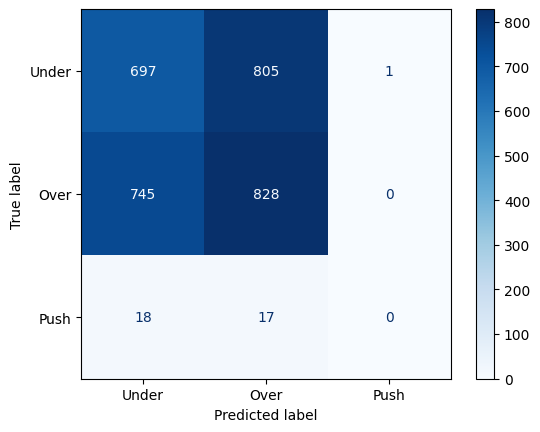

In [242]:
y_true = y_test  # your true labels
# y_pred = [...]  # your predicted labels

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Under","Over","Push"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [243]:
# import numpy as np

In [244]:
# # --- your data ---
# # X = features, y = labels
# # X, y = ...

# # split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42
# )

# # real model
# rf = RandomForestClassifier(n_estimators=80, random_state=42)
# rf.fit(X_train, y_train)
# real_acc = accuracy_score(y_test, rf.predict(X_test))

# # permutation test
# n_permutations = 50
# null_accuracies = []

# for i in range(n_permutations):
#     print(i)
#     y_permuted = np.random.permutation(y_train)
#     rf_null = RandomForestClassifier(n_estimators=80, random_state=42)
#     rf_null.fit(X_train, y_permuted)
#     acc = accuracy_score(y_test, rf_null.predict(X_test))
#     null_accuracies.append(acc)

# null_accuracies = np.array(null_accuracies)

# # p-value (fraction of null models ≥ real model)
# p_value = np.mean(null_accuracies >= real_acc)

# print("Real accuracy:", real_acc)
# print("Mean null accuracy:", null_accuracies.mean())
# print("p-value:", p_value)
